In [1]:
#imports
import matplotlib.pyplot as plt  #plotting
import numpy as np

#retreiving COM and position data
from CenterOfMass2 import CenterOfMass  #finding COM position
import GalaxyMass   #determine galaxy component masses
import OrbitCOM  
from ReadFile import Read

In [71]:
# TASK LIST
# COMPLETE 1. identify COM of merged galaxy and its snapshot
# COMPLETE 2. isolated merged galaxy snapshots
# COMPLETE 3. identify positions of combined MW-M31 halo particles with in COM reference frame
# COMPLETE 4. plot xy, xz, yz projections of dark matter halo (can animate)
# 5. Plot isodensity contours at Rvir for each projection 
# 6. Fit ellipse to isodensity contour using photutils to find ellipticity of each axis. Use this to find axis ratios
# 7. do this for each snapshot and plot axis ratios versus time. 
# 8. (for fun) create 3D plots of halo


#REMINDER: remember to get the high resolution files from nimoy. Can't find them right now for some reason, ask about it later.

#NOTE: Particle types: 1-Dark Matter, 2-Disk Stars, 3-Bulge Stars

In [3]:
#Orbit data in 'Complete Orbit_M31.txt' and 'Complete Orbit_MW.txt'
#Galaxy particle data in MW and M31 folders.

#1. identify COM of merged galaxy adn its snapshot.
#recall from previous assignment: galaxy merger completed after 5.8-6.3 Gyr
#I will split the difference, and take data from 6 gyr onwards. 

#time in each snapshot is recorded in Myr (1 Gyr = 1000 Myr)
#snapshot at 6 Gyr is SNAPSHOT 420 (t = 5.999 Gyr)
# SNAPSHOT 420 ONWARDS (420-800)
# NOW I'd like to find the COM position of the merged galaxy in this snapshot




[-6.9200e+00  1.3208e+02 -1.3000e-01] kpc
[ 17.68 157.91  12.14] kpc


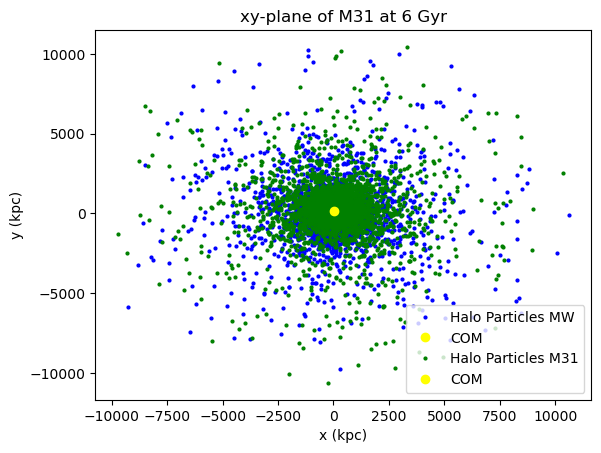

In [28]:
from CenterOfMass_Solution import CenterOfMass
#Start with MW
filename = 'MW_420.txt'  #MW Snapshot at 6 Gyr

#extract data from snapshot
data = np.genfromtxt(filename, dtype=None, names=True, skip_header=3)

#set position and velocity arrays
x = data['x']
y = data['y']
z = data['z']

vx = data['vx']
vy = data['vy']
vz = data['vz']

halo_index = np.where(data['type'] == 1)
disk_index = np.where(data['type'] == 2)
bulge_index = np.where(data['type'] == 3)

#determining COM
MW_420 = CenterOfMass('MW_420.txt',2)  #use disk particles 

COM_position = MW_420.COM_P(volDec=2, delta=0.1)

print(COM_position)

#plotting (xy-plane)
plt.plot(x[halo_index],y[halo_index],'o', color='blue', markersize=2, label='Halo Particles MW') #Plot Halo particles
#plt.plot(COM_position[0], COM_position[1],'o',color='yellow',label='COM') #PLot COM position



#Repeat with M31
filename0 = 'M31_420.txt'  #MW Snapshot at 6 Gyr

#extract data from snapshot
data0 = np.genfromtxt(filename0, dtype=None, names=True, skip_header=3)

#set position and velocity arrays
x = data0['x']
y = data0['y']
z = data0['z']

vx = data0['vx']
vy = data0['vy']
vz = data0['vz']

halo_index0 = np.where(data0['type'] == 1)
disk_index0 = np.where(data0['type'] == 2)
bulge_index0 = np.where(data0['type'] == 3)


#plotting (xy-plane)
plt.plot(x[halo_index],y[halo_index],'o', color='green', markersize=2, label='Halo Particles M31') #Plot Halo particles
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('xy-plane of M31 at 6 Gyr')
plt.legend()

In [6]:
def Combine_Snap_Data(snap_id):
    """This function extracts the data of two snapshots of the same 
    snapshot number from different galaxies and combines their data arrays.
    We are working with the MW and M31 exclusively here. This data is then 
    saved as a text file in the same format as the input file.

    PARAMETERS
    ----------
        snap_id: 'int'
            The snapshot number whose data will be combined

    OUTPUTS
    -------
        combined_data: 'numpy array of floats'
            An array that contains the combined data of the
            MW and M31 for the inputted snapshot number
        time: 'float'
            The time corresponding to the given snapshot in Myr
    """
    #Create filenames
    MW_file = "MW_" + "{:03d}".format(snap_id) + ".txt"
    M31_file = "M31_" + "{:03d}".format(snap_id) + ".txt"

    #extract data from files
    MW_time, MW_total, MW_data = Read(MW_file)
    M31_time, M31_total, M31_data = Read(M31_file)

    #combine the data into one numpy array
    combined_data = np.concatenate((MW_data,M31_data))

    #total number of particles
    tot_part = MW_total + M31_total
    
    #time
    time = MW_time
    
    #write data out to text file in same format as input files
    #output filename
    filename = 'MW_M31_' + "{:03d}".format(snap_id) + '.txt'

    #write data to file
    np.savetxt(filename, combined_data,fmt = "%11.3f"*8, comments='#', 
                   header="{:>11s}{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('type','m', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
    
    return combined_data, time  

In [8]:
#FOR THE ABOVE
# edit function so that it saves combined data to a new text file
# this way I dont have to edit the COM_P function. 
# remember to keep the same format

#write a new readfile function for the above text file format. will make life easier.
import numpy as np
import astropy.units as u

def ReadCombined(filename):
    """This function is designed to read and extract
    data from the combined MW-M31 data files.

    PARAMETERS
    ----------
        filename: 'string'
            The name of the combined data text file.
    OUTPUTS
    -------
        data: 'np.ndarray'
            The array of data extracted from the file.
            Includes mass, ptype, position, and 
            velocity data.
        
    """
    #generate the data array from the file
    data = np.genfromtxt(filename,dtype=None,names=True)

    return data

In [ ]:
#HERE
#Create a function that determines the edge of the halo using the SplashBack Radius
def halo_edge():
    """This function determines the edge of the dark matter halo
    for a given snapshot number using the Splashback Radius. Splashback
    radius is the radius where the density profile of the dark matter halo
    has the steepest slope. This function will find and plot the number 
    density of the merged halo as a function of radius.

    PARAMETERS
    ----------

    OUTPUTS
    -------
    """

#Use Hernquist density profile from previous lab
#Fit to our merged halo to find scale radius (a) 
#Use this to find our SB radius 
#

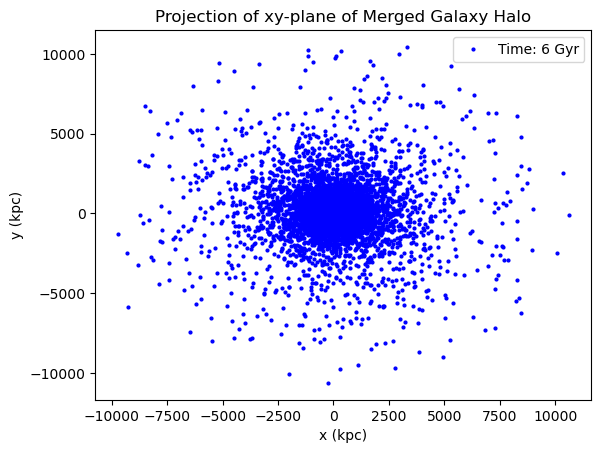

In [10]:
#plotting the combined snapshot 420 data
from CenterOfMass2 import CenterOfMass

data, time = Combine_Snap_Data(420)

#set position and velocity arrays
x = data['x']
y = data['y']
z = data['z']

vx = data['vx']
vy = data['vy']
vz = data['vz']

halo_index = np.where(data['type'] == 1)
disk_index = np.where(data['type'] == 2)
bulge_index = np.where(data['type'] == 3)

#determining COM
#FIND COM LATER. NEED TO EDIT FUNCTION TO TAKE DATA NOT FILENAME AS INPUT.
#M31_420 = CenterOfMass('MW_M31_420.txt',1)  #use disk particles 

#COM_position = M31_420.COM_P(volDec=2, delta=0.1)

#projection of xy-plane
#plotting (xy-plane)
plt.plot(x[halo_index],y[halo_index],'o', color='blue', markersize=2, label='Time: 6 Gyr') #Plot Halo particles
#plt.plot(x[disk_index],y[disk_index],'o', color='green', label='Disk Particles')              #Plot Disk particles
#plt.plot(x[bulge_index],y[bulge_index],'o', color='black', label='Bulge Particles')           #Plot Bulge particles
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Projection of xy-plane of Merged Galaxy Halo')
#plt.plot(COM_position[0], COM_position[1],'o',color='yellow', markersize=7, label='COM') #PLot COM position
plt.legend()
plt.savefig('xy-plane projection.jpg')

In [25]:
# Code for plotting contours
# from https://gist.github.com/adrn/3993992

#imports
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read

#from MassProfile import MassProfile

# for contours
import scipy.optimize as so



def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}

    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))  #change the 0.99 to whatever you want it to be
    
    
    # You might need to add a few levels
    onetwo_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, onetwo_sigma, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.8', '0.95', '0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

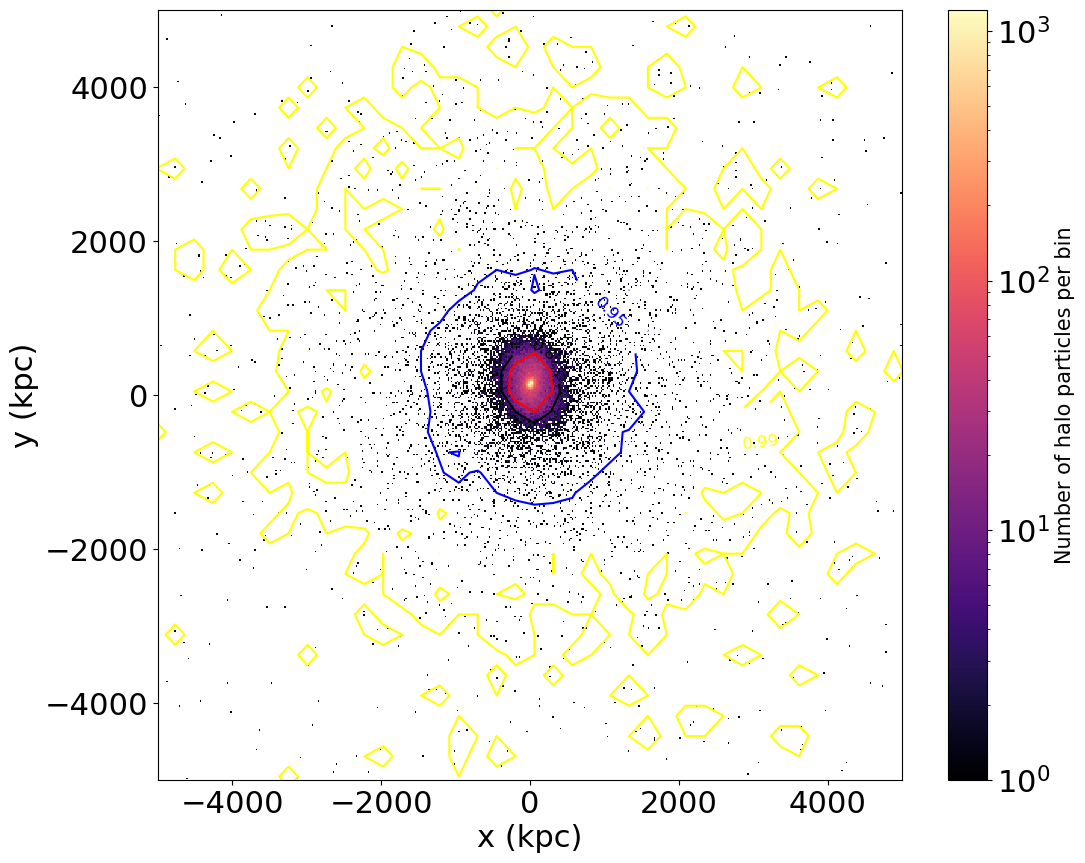

In [33]:
#imports
from matplotlib.colors import LogNorm

#for above plot, we can already see a non-spherical distribution.
#we have some eccentricity in this projection
# 1) Make plots 

# M31 Disk Density 
fig, ax = plt.subplots(figsize=(12, 10))

# ADD HERE
# plot the particle density for M31 using a 2D historgram
# plt.hist2D(pos1,pos2, bins=, norm=LogNorm(), cmap='' )
# cmap options: 
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html  
#   e.g. 'magma', 'viridis'
# can modify bin number to make the plot smoother
plt.hist2d(x[halo_index], y[halo_index], bins=1000, norm=LogNorm(), cmap='magma')

cbar = plt.colorbar()
cbar.set_label("Number of halo particles per bin", fontsize=15)

# ADD HERE
# make the contour plot
# x pos, y pos, contour res, contour res, axis, colors for contours.
# remember to adjust this if there are other contours added
# density_contour(pos1, pos2, res1, res2, ax=ax, colors=[])
density_contour(x[halo_index], y[halo_index], 80, 80, ax=ax, colors=['yellow', 'blue', 'black', 'red'])

# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-5000,5000)
plt.xlim(-5000,5000)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [ ]:

#where rho_crit = 3*(H_0)**2/(8*pi*G)

#plotting rho_crit density contour as some percentage of rho_halo

In [ ]:
#Hernquist Density Profile from Lab4

# import relevant modules 
import astropy.units as u
import numpy as np
from astropy import constants as const # import astropy constants

def hernquist_mass(r,h_a=60*u.kpc, m_halo=1.975): 
    """ Function that defines the Hernquist 1990 mass profile 
    Inputs:
        r: astropy quantity
            Galactocentric distance in kpc
        h_a: astropy quantity
            scale radius of the Hernquist profile in kpc
        m_halo: float
            total halo mass in units of 1e12 Msun 
        
    Ouputs:
        mass: astropy quantity
            total mass within the input radius r in Msun
    """
    a = m_halo*1e12*u.Msun #constants, correcting units

    b = r**2/(h_a + r)**2

    mass = a*b #Hernquist profile
    
    return mass

In [11]:
#from homework 5
from MassProfile_Soln import MassProfile
from MassProfile_Soln import mEncPlot

#initialize mass profile of combined halo
MP = MassProfile('MW_M31', 420)

#find total mass of halo
from GalaxyMass import ComponentMass
#total_mass = ComponentMass('MW_000.txt',1) + ComponentMass('M31_000.txt',1)

#find Hernquist mass and density profiles. 
#mass, density = MP.hernquistMass(r, scale_h, total_mass)

#make density plot of combined halo

mEncPlot('MW_M31', 420, 'Mass Profile', 60.0)

ValueError: too many values to unpack (expected 2)